This notebook looks at the raw data associated with training the models, specifically the raw dataset that contains the training, testing, and dev datasets in totality.


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import spacy
import numpy as np
from collections import defaultdict
from itertools import combinations, product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from d3blocks import D3Blocks
from variables import PROJECTNAME_DATA_PATHS

# Load data


In [9]:
file_path = PROJECTNAME_DATA_PATHS["raw"]("2023_all_ugrad_outlines")
df = pd.read_json(file_path, orient="records", lines=True)

In [10]:
df.iloc[0]

text                 Page 1 of 2\n\nARTSSCI 1B03 / Writing - 2022-2...
STRM                                                              2229
FACULTY DESC                                            Arts & Science
DEPARTMENT                              Arts and Science Baccalaureate
CRSE CAREER                                                       UGRD
SSR COMPONENT                                                      LEC
CRSE_ID                                                         100530
COURSE CODE                                                    ARTSSCI
CATALOG NBR                                                       1B03
CLASS SECTION                                                      C01
CLASS DESCR                                                    Writing
ENROLMENT                                                           84
LAST TERM OFFERED                                            FALL 2022
URL                  https://artsci.mcmaster.ca/app/uploads/2022/08...
cats  

# Get Feature Weights for Each SDG


In [11]:
nlp = spacy.load("en_core_web_lg")


def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


def plot_coefficients(data, sdg):
    # Step 1: Tokenization and Preprocessing
    texts, labels = zip(*data)
    lemmatized_texts = [lemmatize_text(text) for text in texts]
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 3))
    X = vectorizer.fit_transform(lemmatized_texts)

    # Step 2: Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X, labels)

    # Step 3: Extract Feature Importance
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]

    # Step 4: Plot Coefficients
    sorted_indices = np.argsort(coef)
    top_indices = sorted_indices[-10:]  # Plotting top 10 terms for better visibility

    plt.barh(range(len(top_indices)), coef[top_indices])
    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
    plt.xlabel("Coefficient Value")
    plt.title(f"Top Coefficients for {sdg}")
    plt.show()

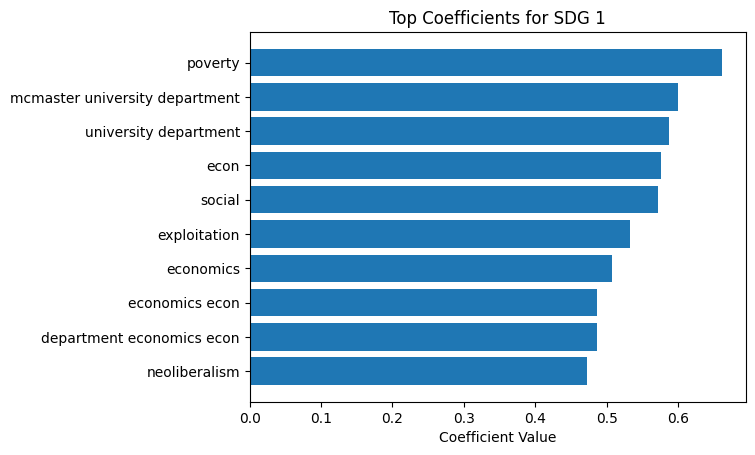

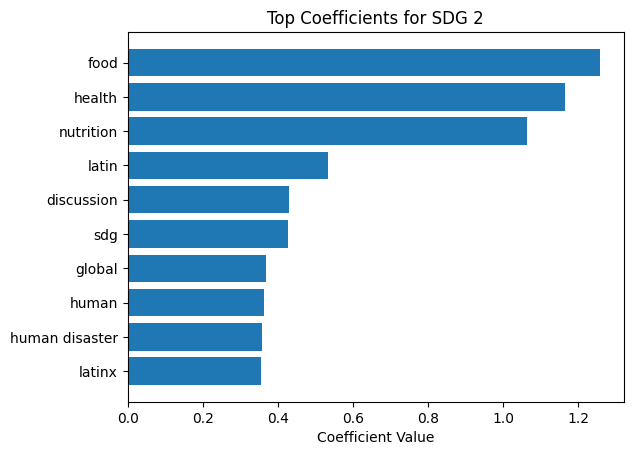

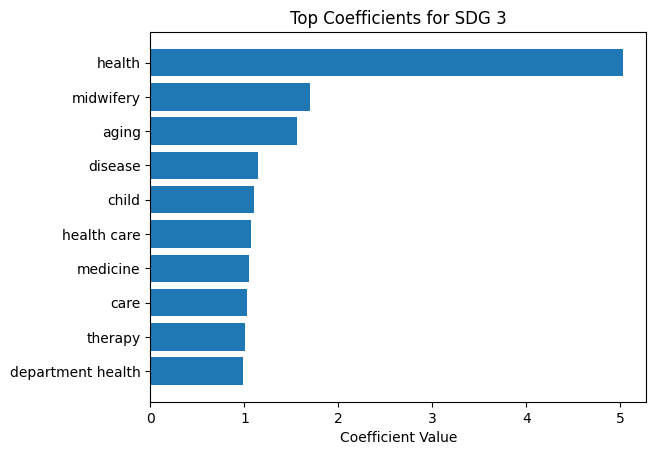

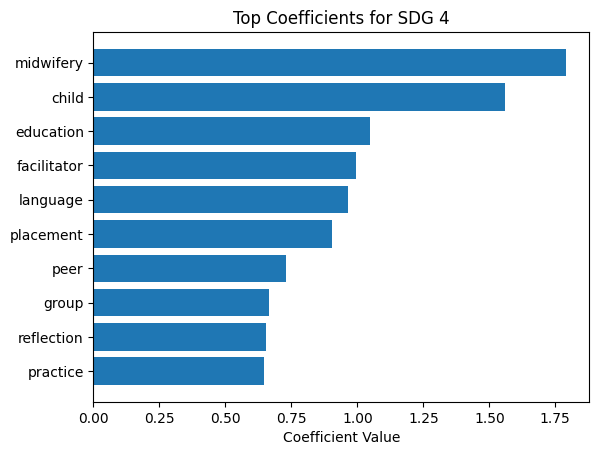

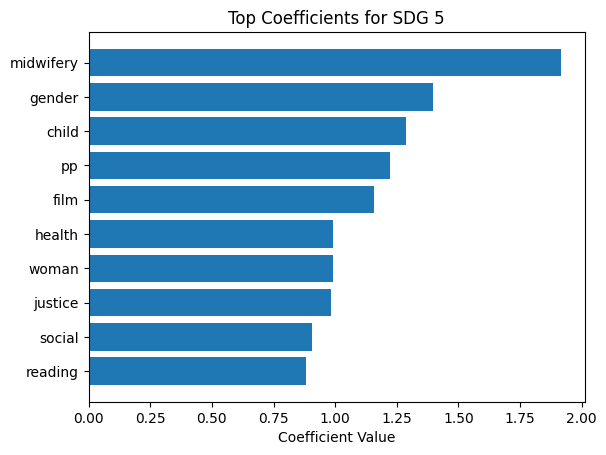

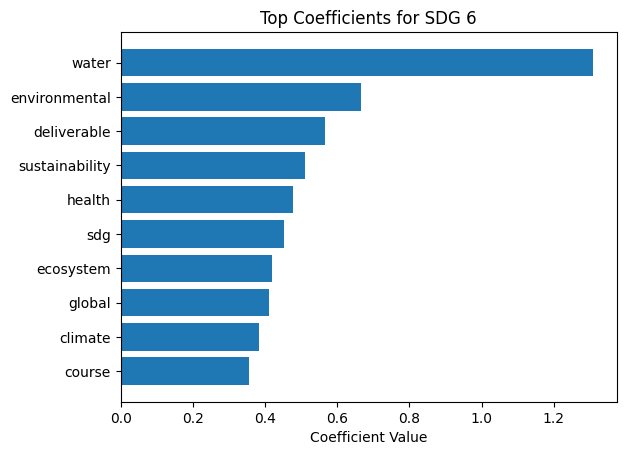

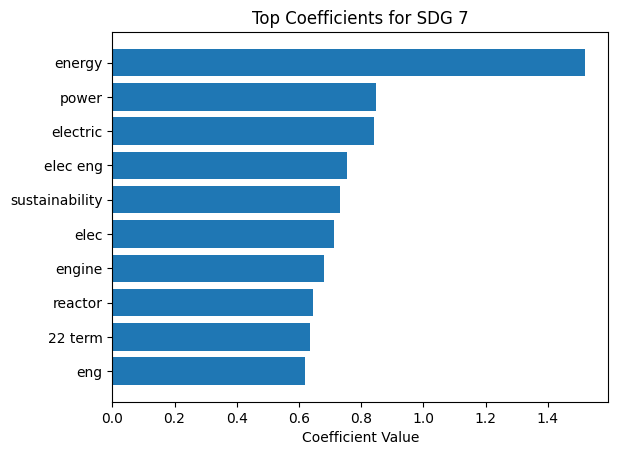

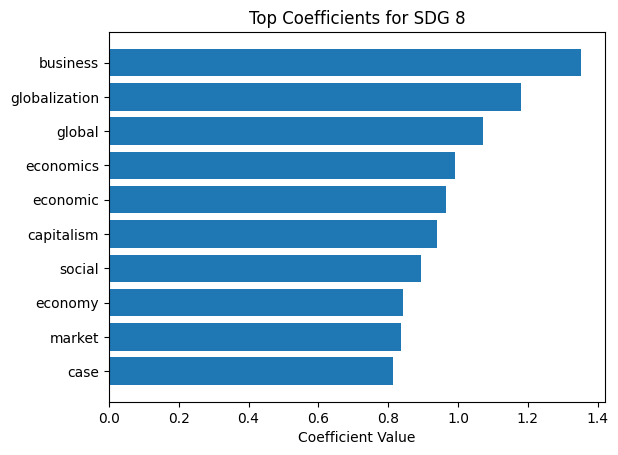

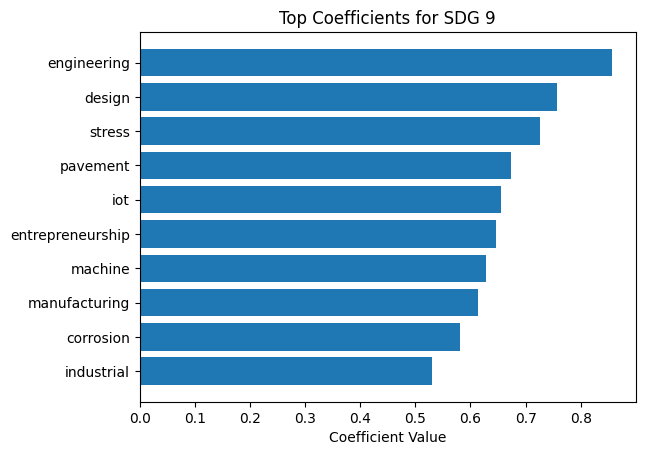

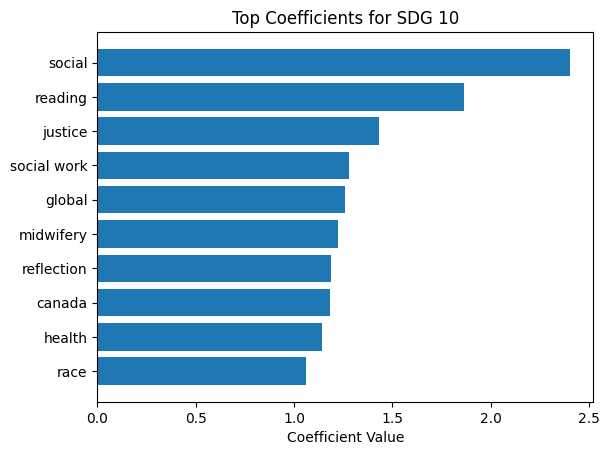

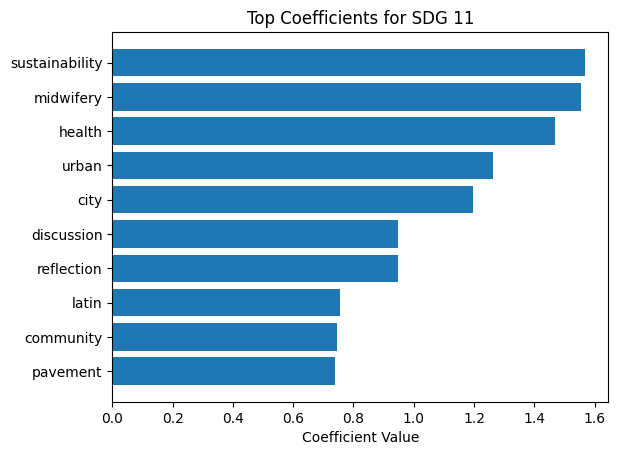

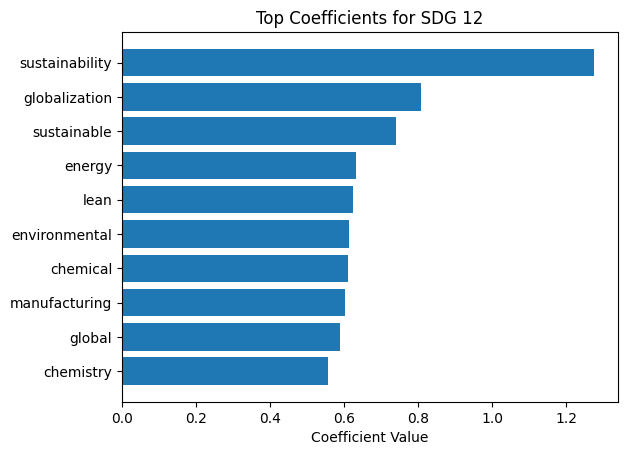

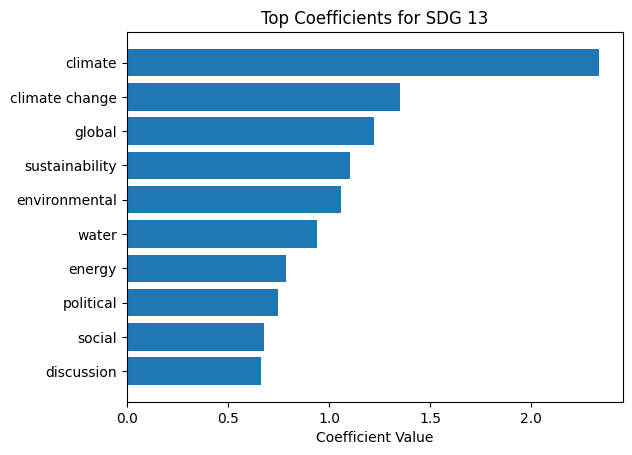

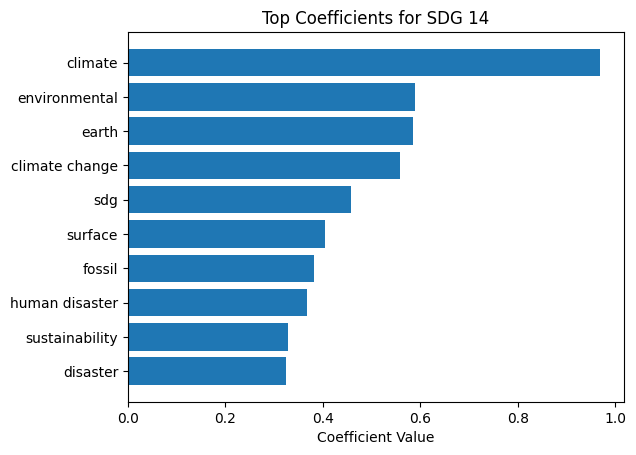

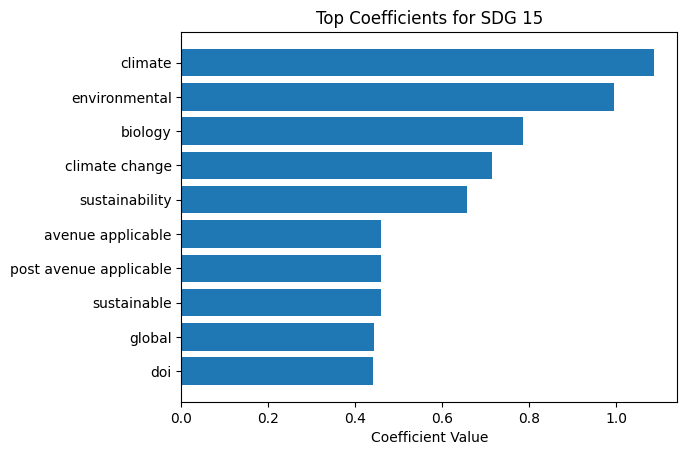

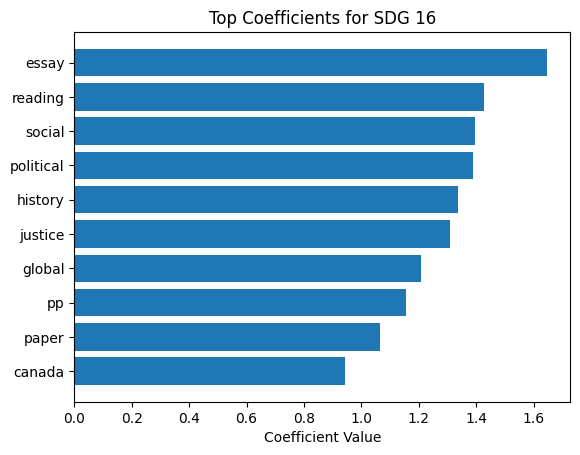

In [12]:
for i in range(1, 17):
    sdg = f"SDG {i}"
    labels = df["labels"].apply(lambda x: sdg in x)
    if sum(labels) < 10:
        continue
    plot_coefficients(zip(df["text"], labels), sdg)

# SDG Co-occurrence


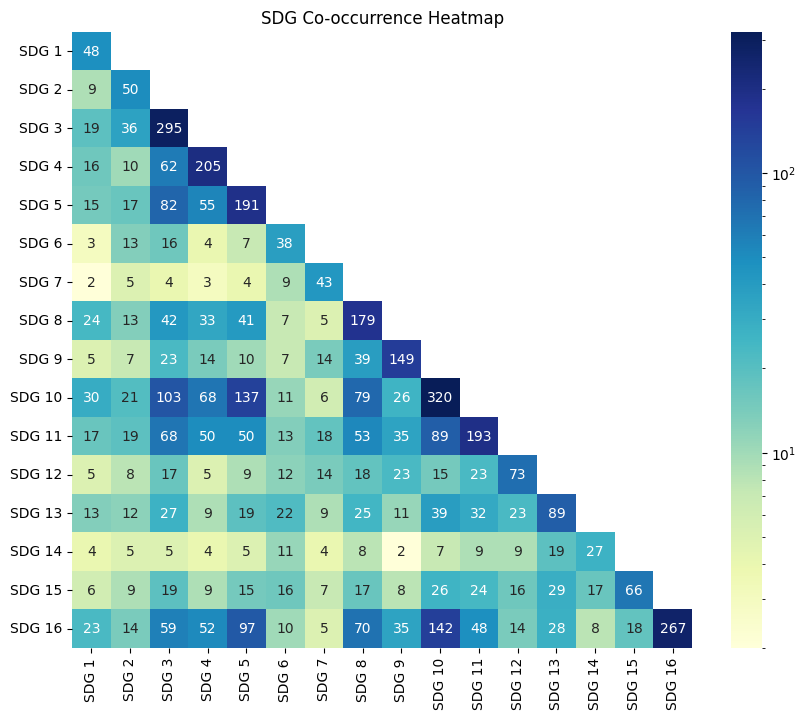

In [13]:
def create_cooccurrence_heatmap(sdg_list):
    # Create a dictionary to store the co-occurrence counts
    cooccurrence_counts = defaultdict(int)
    for sdgs in sdg_list:
        for sdg_1, sdg_2 in product(sdgs, sdgs):
            cooccurrence_counts[(sdg_1, sdg_2)] += 1

    # Convert the co-occurrence counts dictionary to a DataFrame
    df = pd.DataFrame.from_dict(cooccurrence_counts, orient="index", columns=["Count"])
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Pair"}, inplace=True)
    df["v1"], df["v2"] = df["Pair"].apply(lambda x: x[0]), df["Pair"].apply(
        lambda x: x[1]
    )

    # Create a pivot table to reshape the data for the heatmap
    pivot_table = df.pivot(
        index="v1",
        columns="v2",
        values="Count",
    ).fillna(0)

    order = [f"SDG {i}" for i in range(1, 17)]
    pivot_table = pivot_table.loc[order, order]

    mask = np.triu(np.ones_like(pivot_table, dtype=bool), k=1)

    pivot_table = pivot_table.astype(int)

    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pivot_table, annot=True, cmap="YlGnBu", norm=LogNorm(), fmt="d", mask=mask
    )
    plt.title("SDG Co-occurrence Heatmap")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    return df


cc_df = create_cooccurrence_heatmap(df["labels"])

In [14]:
def get_cc_df(sdg_list):
    # Create a dictionary to store the co-occurrence counts
    cooccurrence_counts = defaultdict(int)
    for sdgs in sdg_list:
        for sdg_1, sdg_2 in combinations(sdgs, 2):
            cooccurrence_counts[(sdg_1, sdg_2)] += 1

    # Convert the co-occurrence counts dictionary to a DataFrame
    df = pd.DataFrame.from_dict(cooccurrence_counts, orient="index", columns=["weight"])
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Pair"}, inplace=True)
    df["source"], df["target"] = df["Pair"].apply(lambda x: x[0]), df["Pair"].apply(
        lambda x: x[1]
    )
    color_map = {
        "SDG 1": "#e5233d",
        "SDG 2": "#dda73a",
        "SDG 3": "#4ca146",
        "SDG 4": "#c5192d",
        "SDG 5": "#ef402c",
        "SDG 6": "#27bfe6",
        "SDG 7": "#fbc412",
        "SDG 8": "#a31c44",
        "SDG 9": "#f26a2d",
        "SDG 10": "#e01483",
        "SDG 11": "#f89d2a",
        "SDG 12": "#bf8d2c",
        "SDG 13": "#407f46",
        "SDG 14": "#1f97d4",
        "SDG 15": "#59ba48",
        "SDG 16": "#126a9f",
    }

    df["color"] = df["source"].apply(lambda s: color_map[s])

    return df


cc_df = get_cc_df(df["labels"])

In [15]:
cc_df

,Pair,weight,source,target,color
0,"(SDG 16, SDG 5)",95,SDG 16,SDG 5,#126a9f
1,"(SDG 16, SDG 3)",59,SDG 16,SDG 3,#126a9f
2,"(SDG 5, SDG 3)",82,SDG 5,SDG 3,#ef402c
3,"(SDG 10, SDG 16)",98,SDG 10,SDG 16,#e01483
4,"(SDG 10, SDG 8)",77,SDG 10,SDG 8,#e01483
...,...,...,...,...,...
193,"(SDG 2, SDG 1)",2,SDG 2,SDG 1,#dda73a
194,"(SDG 2, SDG 7)",1,SDG 2,SDG 7,#dda73a
195,"(SDG 14, SDG 5)",1,SDG 14,SDG 5,#1f97d4
196,"(SDG 12, SDG 1)",3,SDG 12,SDG 1,#bf8d2c


In [16]:
d3 = D3Blocks()

# Plot
d3.chord(cc_df, color="source", notebook=True)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Create directory: [C:\Users\edalatma\AppData\Local\Temp\d3blocks]
[d3blocks] >INFO> filepath is set to [C:\Users\edalatma\AppData\Local\Temp\d3blocks\chord.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
c:\Users\edalatma\Desktop\Programs\sdg_text_analytics\.tox\py311\Lib\site-packages\d3blocks\utils.py:604: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if 'weight' in X.columns: X['weight'] = X['weight'].astype(float)
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colo